# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [21]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

1.13.0


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [22]:
#Define transforms
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create training set and define training dataloader
test_data = torchvision.datasets.CIFAR10('data', train=False,
                             download=True, transform=test_transforms)
train_valid_data = torchvision.datasets.CIFAR10('data', train=True,
                              download=True, transform=train_transforms)

# Added: Perform split
train_size = int(np.floor(0.8 * len(train_valid_data)))
valid_size = len(train_valid_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_valid_data, [train_size, valid_size])
    
# Create dataloader
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [23]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
        image = images[i]/2 + 0.5
        image = image.numpy()
        plt.imshow(np.transpose(image,(1,2,0)))
        plt.show()

bird


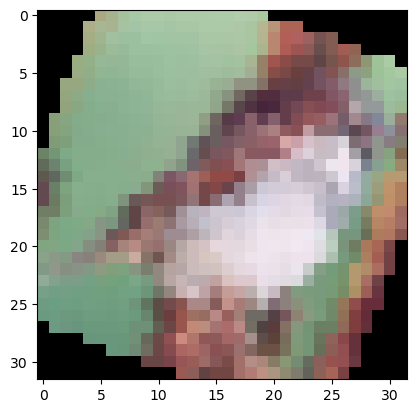

dog


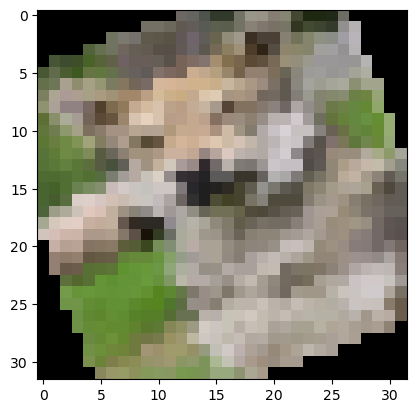

plane


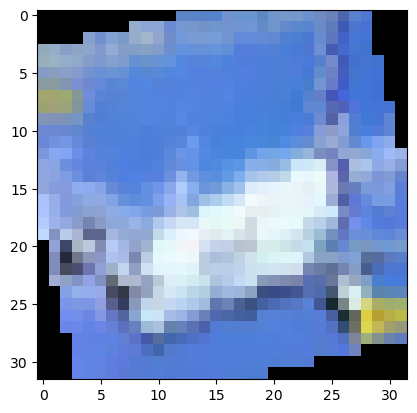

truck


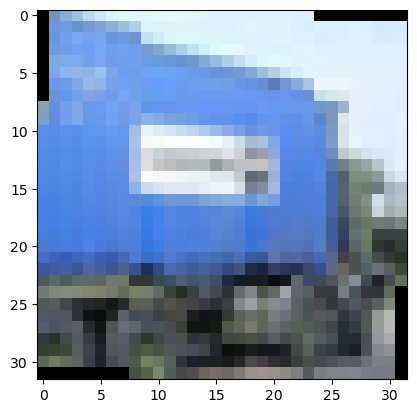

truck


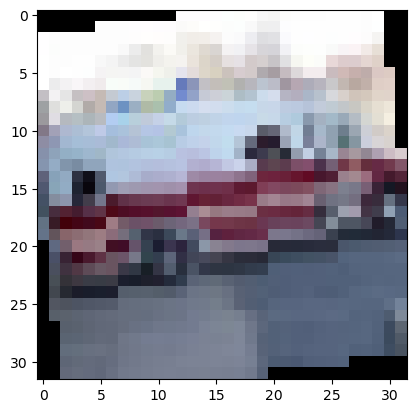

In [24]:
# Explore data
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [25]:
class Network(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # 32x32x3
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) #16x16x16
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 8x8x32
        self.pool = nn.MaxPool2d(2, 2) # To reduce images by half
        self.fc1 = nn.Linear(64 * 4 * 4, 512) # 4x4 after applying 3 times MaxPool2d
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4) # To flatten image input
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)        
        return x

    
model = Network()
    

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [26]:
# Define the loss
#Why use neg log loss? It generally maximizes the overall probability of the data and also smaller/quick trainer
criterion = nn.NLLLoss()

# Define the optimize
optimizer = optim.SGD(model.parameters(), lr=0.003)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);
print(f'Training on device {device}')

epochs = 30
min_valid_loss = np.Inf
train_log = {
    "train_losses" : list(),
    "valid_losses" : list(),
    "valid_accuracy" : list()
}

# Train Process
for epoch in range(epochs):
    train_loss = 0
    for inputs, labels in trainloader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

# Validation
    valid_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            valid_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    model.train()
    
    avg_train_loss = train_loss/len(trainloader)
    avg_valid_loss = valid_loss/len(validloader)
    avg_valid_acc = accuracy/len(validloader)
    train_log["train_losses"].append(avg_train_loss)
    train_log["valid_losses"].append(avg_valid_loss)
    train_log["valid_accuracy"].append(avg_valid_acc)
    print(f"Epoch {epoch+1:03d}/{epochs:03d}.. "
          f"Train loss: {avg_train_loss:.3f}.. "
          f"Valid loss: {avg_valid_loss:.3f}.. "
          f"Valid accuracy: {avg_valid_acc:.3f}")

Training on device cpu
Epoch 001/030.. Train loss: 2.301.. Valid loss: 2.297.. Valid accuracy: 0.179
Epoch 002/030.. Train loss: 2.285.. Valid loss: 2.242.. Valid accuracy: 0.180
Epoch 003/030.. Train loss: 2.145.. Valid loss: 2.036.. Valid accuracy: 0.251
Epoch 004/030.. Train loss: 2.011.. Valid loss: 1.932.. Valid accuracy: 0.288
Epoch 005/030.. Train loss: 1.915.. Valid loss: 1.827.. Valid accuracy: 0.319
Epoch 006/030.. Train loss: 1.793.. Valid loss: 1.690.. Valid accuracy: 0.382
Epoch 007/030.. Train loss: 1.690.. Valid loss: 1.616.. Valid accuracy: 0.409
Epoch 008/030.. Train loss: 1.628.. Valid loss: 1.557.. Valid accuracy: 0.433
Epoch 009/030.. Train loss: 1.585.. Valid loss: 1.499.. Valid accuracy: 0.454
Epoch 010/030.. Train loss: 1.544.. Valid loss: 1.461.. Valid accuracy: 0.470
Epoch 011/030.. Train loss: 1.506.. Valid loss: 1.438.. Valid accuracy: 0.478
Epoch 012/030.. Train loss: 1.472.. Valid loss: 1.407.. Valid accuracy: 0.484
Epoch 013/030.. Train loss: 1.437.. Valid

Plot the training loss (and validation loss/accuracy, if recorded).

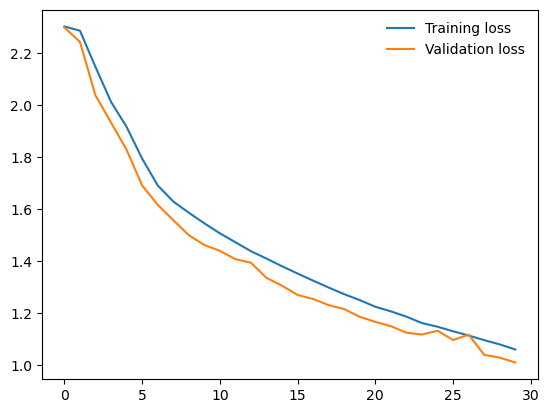

In [28]:
plt.plot(train_log["train_losses"], label='Training loss')
plt.plot(train_log["valid_losses"], label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [29]:
print(f'Test Accuracy: {(accuracy / len(testloader) * 100):.2f}%')

Test Accuracy: 64.38%


## Saving your model
Using `torch.save`, save your model for future loading.

In [31]:
checkpoint = {
    'state_dict': model.state_dict(),
    'optim_dict': optimizer.state_dict()
    }

torch.save(checkpoint, f='model_checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?




>- Based on the evaluation above which has achieved a (64.38% vs 70%) accuracy.
For now, i would recommend purchasing the Detectocorps model rather than in-house.
>- Compared to the Convolutional Deep Belief Network(78.9%) achieved by having two-layered classification on fine-tuned filters on images. Also noting the use of pipeline parallelism (GPipe): that is implementing syncronous gradient updates achieves (99.0%) byHuang et al., 2018. Our model is far from achieving those architectures but is definitely a must achieve goal for the company.  
>- Using the simple nn.Linear creates single layer feed forward network with n inputs and m output.
>- To achieve (70%+ ) i would re-architecture the neural network, explore different optimizers, loss functions and recheck number of hidden layers factor, i also noted changing the number of epoch to 25 achieves a higher accuracy in this case. I am certain more accuracy is achievable.


## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).